# Выбор локации для скважины

## Описание проекта

Компания «ГлавРосГосНефть» планирует увеличить объём добычи нефти. Нужно решить, где бурить новую скважину.

В нашем распоряжении данные о пробах нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цель исследования** - построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

**Задачи исследования**:

* исследовать входные и целевой признаки;
* провести корреляционный анализ;
* создать модель, которая будет прогнозировать объём запасов в скважине для каждого региона;
* рассчитать достаточный объём сырья для безубыточной разработки новой скважины;
* оценить риски и прибыль для каждого региона с учётом предсказаний модели;
* предложить регион для разработки скважин.

**Условия задачи**:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Ход исследования**:

В начале подготовим данные: проверим датасеты на наличие полных и неявных дубликатов, подсчитаем пропуски в данных и проверим соответствие значений в столбцах их типам. 

Далее проведём исследовательский анализ данных. Построим графики с распределением и числовым размахом для каждой переменной, попробуем выявить выбросы. Перед построением модели необходимо будет провести корреляционный анализ: построить матрицу корреляций для целевого и входных признаков, оценить наличие мультиколлинеарности.

Потом приступим к построению пайплайна. Для масштабирования количественных признаков используем несколько скейлеров. Для обучения выберем 3 модели линейной регрессии (LinearRegression, Ridge, Lasso) подберём для них гиперпараметры с помощью RandomizedSearchCV. В результате выберем лучшую модель по метрике RMSE. Определим средний запас предсказанного сырья для каждого региона и сравним с показателем объёма сырья для безубыточной разработки новой скважины. Напишем функцию для расчёта прибыли, учитывая скважины с максимальными значениями предсказаний. Затем посчитаем риски и прибыль для каждого региона, используя технику Bootstrap. Сформулируем итоговый вывод и выберем регион с наименьшим риском отрицательной прибыли и наибольшей средней прибылью.

## Импорт библиотек, модулей

In [2]:
%config InlineBackend.figure_format='svg'
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import numpy as np
import phik
import math
import shap
# импорт библиотек pandas, seaborn, matplotlib, numpy, shap

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy import stats as st
from scipy.stats import shapiro, anderson
from statsmodels.stats.outliers_influence import variance_inflation_factor
# импорт библиотек scipy, statsmodels

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# загружаем классы Pipeline, train_test_split

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
# загружаем классы для подготовки данных, работы с пропусками

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from optuna.integration import OptunaSearchCV
from optuna import distributions
# импортируем классы RandomizedSearchCV и OptunaSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# загружаем нужные модели

from sklearn.metrics import make_scorer, mean_squared_error
# загружаем функции для работы с метриками

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
state = np.random.RandomState(12345)

## Загрузка и обзор данных

In [5]:
try:   
    region_1 = pd.read_csv('/datasets/geo_data_0.csv')
    region_2 = pd.read_csv('/datasets/geo_data_1.csv')
    region_3 = pd.read_csv('/datasets/geo_data_2.csv')
except: 
    region_1 = pd.read_csv('/Users/galina/Desktop/Яндекс.Практикум/Data Science/Спринт 13 ML в бизнесе/Спринт 13 Проект/geo_data_0.csv')
    region_2 = pd.read_csv('/Users/galina/Desktop/Яндекс.Практикум/Data Science/Спринт 13 ML в бизнесе/Спринт 13 Проект/geo_data_1.csv')
    region_3 = pd.read_csv('/Users/galina/Desktop/Яндекс.Практикум/Data Science/Спринт 13 ML в бизнесе/Спринт 13 Проект/geo_data_2.csv')
# чтение файлов с данными

In [6]:
def get_df_info(df):
    display(df.head(10))
    display(df.info())
    display(df.describe(include='all'))
    display(df.columns)
# создание функции для вывода характеристик датафрейма

In [7]:
df_dict = {'region_1': region_1, 
           'region_2': region_2, 
           'region_3': region_3}
# создание словаря с датафреймами

In [8]:
for name, value in df_dict.items():
    print('')
    print(f'Характеристики датафрейма: {name} \n')
    get_df_info(value)
# вывод характеристик для датафреймов с помощью цикла   


Характеристики датафрейма: region_1 



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,fiKDv,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')


Характеристики датафрейма: region_2 



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,wt4Uk,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.141296,-4.796579,2.494541,68.825000
std,NaN,8.965932,5.119872,1.703572,45.944423
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298551,-8.267985,1.000021,26.953261
50%,NaN,1.153055,-4.813172,2.011479,57.085625
75%,NaN,8.621015,-1.332816,3.999904,107.813044


Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')


Характеристики датафрейма: region_3 



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,VF7Jo,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.002023,-0.002081,2.495128,95.000000
std,NaN,1.732045,1.730417,3.473445,44.749921
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162288,-1.174820,0.130359,59.450441
50%,NaN,0.009424,-0.009482,2.484236,94.925613
75%,NaN,1.158535,1.163678,4.858794,130.595027


Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

На первый взгляд аномальных значений в датафреймах не наблюдается. Есть только скважины с минимальным объёмом запасов `product` - **0**. Подробнее рассмотрим такие строки на этапе исследовательского анализа данных.  

Можно заметить, что во всех датафреймах есть **дублирующиеся** идентификаторы `id`. Нужно проверить, совпадают ли у данных скважин признаки точек.

### Вывод

Датафреймы region_1, region_2 и region_3 содержат данные с характеристиками скважин в каждом регионе:

* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

Перед построением модели проверим наши датафреймы на наличие пропусков, неявных и полных дубликатов, а также на корректность типов данных в колонках. Далее изучим распределение каждого параметра и избавимся от выбросов, если это будет необходимо.

## Предобработка данных

Для начала подробно рассмотрим характеристики каждого датасета:
* region_1
* region_2
* region_3

In [9]:
def data_overview(df, name):
    
    print(f'''Таблица {name}
    
Названия столбцов: 

{df.columns.values}
''')
    print(f'Количество явных дубликатов: {df.duplicated(subset=list(df.columns[1:])).sum()} \n')
    display(df[df.duplicated(subset=list(df.columns))])
    # вывод строк-дубликатов
    print('')
    for category in list(df.select_dtypes(include=[object]).columns):
        print(f'Число уникальных совпадений в столбце {category}:')
        display(df[category].value_counts())
        # подсчёт уникальных значений в колонках
        print('') 
    print(f'Количество пропусков в датафрейме {name}: \n')
    print(df.isna().sum())
    # подсчёт пропусков
    print('')
    print(f'Типы данных по столбцам в {name}: \n')
    # отображение типов данных
    print(df.dtypes)
# создание функции для вывода информации по наличию пропусков, дубликатов, названиям столбцов, тиипам данных   

In [10]:
data_overview(region_1, 'region_1')
# вызов функции data_overview() для region_1

Таблица region_1
    
Названия столбцов: 

['id' 'f0' 'f1' 'f2' 'product']

Количество явных дубликатов: 0 



,id,f0,f1,f2,product



Число уникальных совпадений в столбце id:


fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
        ..
x8osI    1
gZ7tR    1
Zw8hj    1
zcrQO    1
1CWhH    1
Name: id, Length: 99990, dtype: int64


Количество пропусков в датафрейме region_1: 

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Типы данных по столбцам в region_1: 

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


In [11]:
(region_1[region_1['id'].isin(region_1['id']
                              .value_counts()
                              .reset_index()
                              .query('id > 1')['index'])]
                        .sort_values(by='id')
)
# срез данных

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


В данных таблицы region_1 есть строки с повторяющимися идентификаторами `id`, но признаки точек в них отличаются. Возможно, такие дубликаты появились в результате технической ошибки при сборе данных. Оставим как есть, далее при обучении модели мы не будем использовать столбец `id`.

In [12]:
data_overview(region_2, 'region_2')
# вызов функции data_overview() для region_2

Таблица region_2
    
Названия столбцов: 

['id' 'f0' 'f1' 'f2' 'product']

Количество явных дубликатов: 0 



,id,f0,f1,f2,product



Число уникальных совпадений в столбце id:


wt4Uk    2
LHZR0    2
5ltQ6    2
bfPNe    2
kBEdx    1
        ..
eup2F    1
5Z8yO    1
HwvM0    1
MZgPf    1
relB0    1
Name: id, Length: 99996, dtype: int64


Количество пропусков в датафрейме region_2: 

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Типы данных по столбцам в region_2: 

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


In [13]:
(region_2[region_2['id'].isin(region_2['id']
                              .value_counts()
                              .reset_index()
                              .query('id > 1')['index'])]
                        .sort_values(by='id')
)
# срез данных

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


В region_2 также есть дублирующиеся идентификаторы `id`. Таких строк немного, необходимости удалять дубли нет.

In [14]:
data_overview(region_3, 'region_3')
# вызов функции data_overview() для region_3

Таблица region_3
    
Названия столбцов: 

['id' 'f0' 'f1' 'f2' 'product']

Количество явных дубликатов: 0 



,id,f0,f1,f2,product



Число уникальных совпадений в столбце id:


VF7Jo    2
KUPhW    2
xCHr8    2
Vcm5J    2
fwXo0    1
        ..
bdHH6    1
copuS    1
hZYbu    1
7K1cP    1
V9kWn    1
Name: id, Length: 99996, dtype: int64


Количество пропусков в датафрейме region_3: 

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Типы данных по столбцам в region_3: 

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


In [15]:
(region_3[region_3['id'].isin(region_3['id']
                              .value_counts()
                              .reset_index()
                              .query('id > 1')['index'])]
                        .sort_values(by='id')
)
# срез данных

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


В датафрейме region_3 полных дубликатов также нет.

### Вывод

Пропусков и явных полных дубликатов в таблицах не нашлось. Все типы данных соответствуют значениям в столбцах. 

Нам удалось обнаружить только строки с повторяющимися `id`, которые удалять не нужно. 

## Исследовательский анализ данных

In [16]:
set(list(region_1['id'].values)).intersection(list(region_2['id'].values))
# элементы пересечения двух множеств

{'CXJ2r',
 'L1Fdm',
 'Mp3uM',
 'Q64YW',
 'Y2udP',
 'g3RRG',
 'gnA83',
 'it2OW',
 'mpZhE',
 'pGQRI'}

In [17]:
set(list(region_1['id'].values)).intersection(list(region_3['id'].values))
# элементы пересечения двух множеств

{'2tyMi',
 '5ssQt',
 'G6k8A',
 'H2jd8',
 'LhkAh',
 'PyNp5',
 'Suyut',
 'TXPOv',
 'eVdPR',
 'i2csb',
 'kpKGs',
 'lFHA5',
 'rAJA6',
 'scFN4',
 'tgOl6',
 'uSye4',
 'wqgPo'}

In [18]:
set(list(region_3['id'].values)).intersection(list(region_2['id'].values))
# элементы пересечения двух множеств

{'D8TNs', 'TAqwC', 'g2I86', 'uMqiK'}

Сразу в нескольких датафреймах присутствуют скважины с одинаковыми `id`. Посмотрим на строки-пересечения таблиц region_3 и region_2.

In [19]:
region_3[region_3['id']
         .isin(list(set(list(region_3['id'].values))
                    .intersection(list(region_2['id'].values))))].sort_values(by='id')
# срез данных: вывод элементов, которые входят в список пересечения множеств

,id,f0,f1,f2,product
61622,D8TNs,0.280382,0.061393,4.887870,114.943876
80750,TAqwC,-0.176382,-0.503558,1.877303,38.618695
17007,g2I86,-1.616730,1.110380,4.226968,107.940639
40478,uMqiK,-1.772509,0.152085,-0.422541,119.682928


In [20]:
region_2[region_2['id']
         .isin(list(set(list(region_3['id'].values))
                    .intersection(list(region_2['id'].values))))].sort_values(by='id')
# срез данных: вывод элементов, которые входят в список пересечения множеств

,id,f0,f1,f2,product
44738,D8TNs,-0.646266,3.667055,1.006161,30.132364
28877,TAqwC,-13.045712,-13.056006,0.007640,3.179103
92366,g2I86,17.818406,2.946716,0.991640,26.953261
38405,uMqiK,2.734183,-3.102346,-0.002654,0.000000


Несмотря на совпадающие `id`, признаки скважин в датафреймах разные. 

In [21]:
matplotlib.rcParams['font.family'] = 'serif'
# изменение шрифта

def show_distribution_graphs(df, df_name):
    
    print('')
    print(f'Датафрейм {df_name}: \n')
    
    for column in list(df.select_dtypes(include=[float, int]).columns):
    
        fig = plt.figure(figsize=(9, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        # создание сетки из подграфиков
        ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
        ax2.grid(which='major', linewidth=1, color='gray',  alpha=0.2)
        # изменение параметров сетки
        ax2.yaxis.set_minor_locator(AutoMinorLocator())
        ax2.tick_params(which='minor', length=2, width=1)
        # изменение параметров делений на осях
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        # удаление линий осей
        ax1.xaxis.set_visible(False)
    
        fig.suptitle(f'''Гистограмма и диаграмма размаха параметра: \n{column}''', 
                     fontsize=14,
                     fontweight='demi',
                     color='#1B1B17')
        # добавление заголовка

        df.boxplot(column, 
                   ax=ax1,
                   widths=0.3,
                   showmeans=True, 
                   meanline=True, 
                   color='black',
                   flierprops=dict(marker='D', markerfacecolor='white', markeredgecolor='#99D0D3', linewidth=2),
                   medianprops=dict(linewidth=1.7, color='#B47EB2'),
                   boxprops=dict(linewidth=1.5, color='#99D0D3'),
                   meanprops=dict(linewidth=1.5, color='#2E958C')
                  )
        # создание диаграммы размаха
    
        df.hist(column, ax=ax2, color='#C8C3C9', bins=12)
        ax2.set_title(None)
        # создание гистограммы
    
        fig.tight_layout()
        plt.show()
        # вывод графиков
        
        shapiro_test, anderson_test = shapiro(df[column]), anderson(df[column])
        print(shapiro_test)
        print('')
        print(anderson_test)
        # получение результатов тестов Шапиро-Уилка и Андерсона-Дарлинга на нормальность распределения
        display(round(df[column].describe().loc[['mean', 'std', 'max', 'min', '50%']], 2))
        print(f'Коэффициент асимметрии: {round(df[column].skew(), 2)} \n')
        print(f'Коэффициент эксцесса: {round(df[column].kurt(), 2)} \n')
# создание функции для построения графиков распределения числовых величин: гистограммы и диаграммы размаха


Датафрейм region_1: 



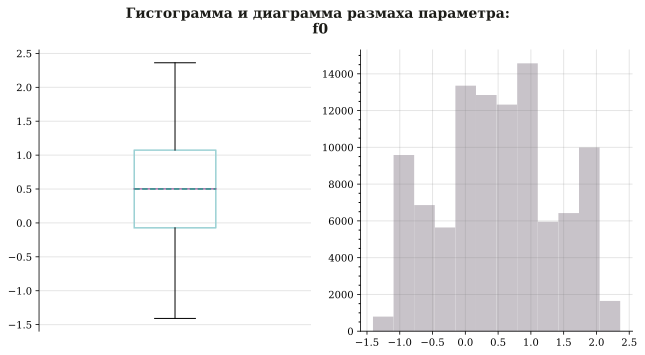

ShapiroResult(statistic=0.9720331430435181, pvalue=0.0)

AndersonResult(statistic=500.33876248168235, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.5004193306434167, scale=0.8718320065520454)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean    0.50
std     0.87
max     2.36
min    -1.41
50%     0.50
Name: f0, dtype: float64

Коэффициент асимметрии: -0.0 

Коэффициент эксцесса: -0.87 



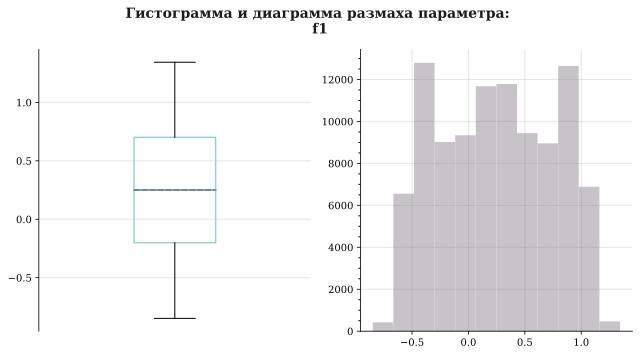

ShapiroResult(statistic=0.9573715329170227, pvalue=0.0)

AndersonResult(statistic=1128.7687130399136, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.25014302801754934, scale=0.5044326721863978)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean    0.25
std     0.50
max     1.34
min    -0.85
50%     0.25
Name: f1, dtype: float64

Коэффициент асимметрии: 0.0 

Коэффициент эксцесса: -1.19 



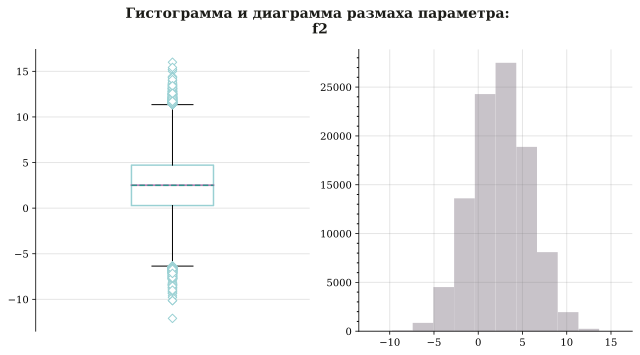

ShapiroResult(statistic=0.9998478889465332, pvalue=8.351793439942412e-06)

AndersonResult(statistic=2.559594603459118, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2.5026469402575238, scale=3.248247649371697)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean     2.50
std      3.25
max     16.00
min    -12.09
50%      2.52
Name: f2, dtype: float64

Коэффициент асимметрии: -0.0 

Коэффициент эксцесса: -0.11 



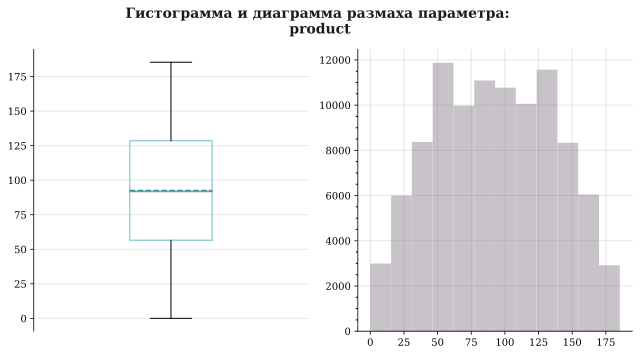

ShapiroResult(statistic=0.9789732694625854, pvalue=0.0)

AndersonResult(statistic=541.9935499982093, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=92.50000000000001, scale=44.28869113685337)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean     92.50
std      44.29
max     185.36
min       0.00
50%      91.85
Name: product, dtype: float64

Коэффициент асимметрии: 0.0 

Коэффициент эксцесса: -0.95 



In [22]:
show_distribution_graphs(region_1, 'region_1')
# вызов функции show_distribution_graphs для region_1

Распределения параметров точек `f0`, `f1`, `f2` в **region_1** *не являются нормальными*. Тестовые статистики Андерсона-Дарлинга больше критических значений для каждого уровня значимости. Выбросы наблюдаются на диаграмме размаха параметра `f2`, при этом среднее значение не смещено и совпадает с медианой. 

Медианный показатель объёма запасов в скважинах - **91.85** тыс. баррелей. Несмотря на коэффициент асимметрии, стремящийся к нулю, распределение *нельзя назвать нормальным*. Отрицательный эксцесс (-0.95) означает, что распределение сглаженное и в данных наблюдается меньше выбросов, чем в нормальном распределении.


Датафрейм region_2: 



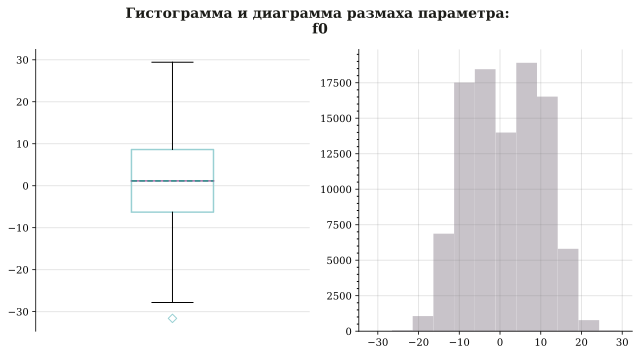

ShapiroResult(statistic=0.9784496426582336, pvalue=0.0)

AndersonResult(statistic=802.4293767559138, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1.1412958353989027, scale=8.965931501139101)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean     1.14
std      8.97
max     29.42
min    -31.61
50%      1.15
Name: f0, dtype: float64

Коэффициент асимметрии: 0.0 

Коэффициент эксцесса: -0.95 



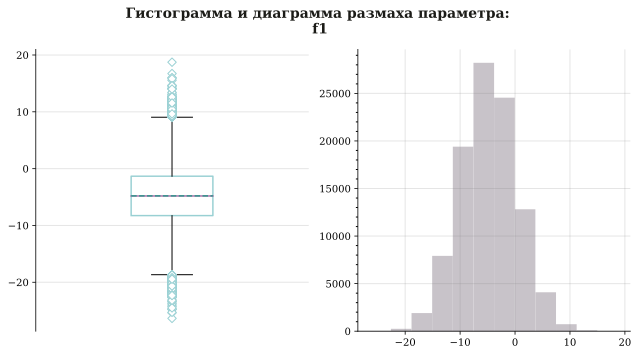

ShapiroResult(statistic=0.9999606609344482, pvalue=0.30398082733154297)

AndersonResult(statistic=0.6486431970988633, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-4.796579148792222, scale=5.11987163170479)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean    -4.80
std      5.12
max     18.73
min    -26.36
50%     -4.81
Name: f1, dtype: float64

Коэффициент асимметрии: 0.02 

Коэффициент эксцесса: -0.02 



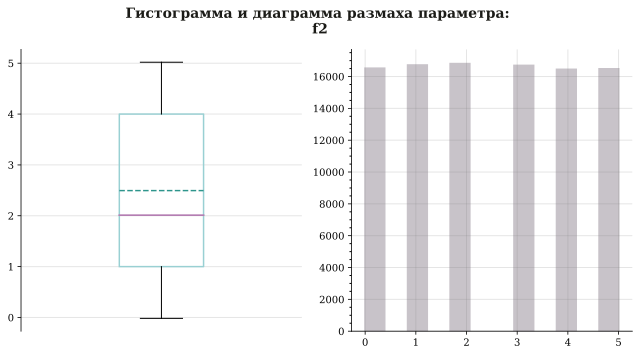

ShapiroResult(statistic=0.9083258509635925, pvalue=0.0)

AndersonResult(statistic=2750.283735100151, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2.494541252382821, scale=1.7035715179903796)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean    2.49
std     1.70
max     5.02
min    -0.02
50%     2.01
Name: f2, dtype: float64

Коэффициент асимметрии: 0.01 

Коэффициент эксцесса: -1.26 



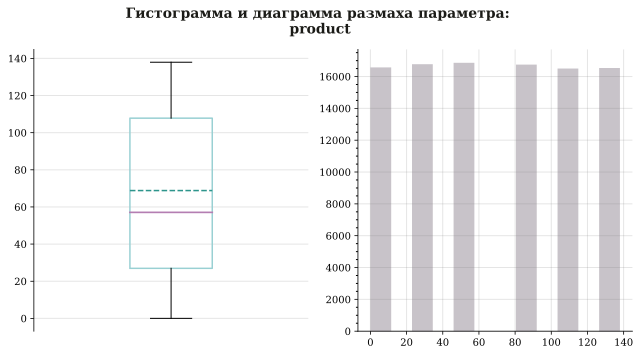

ShapiroResult(statistic=0.9186310172080994, pvalue=0.0)

AndersonResult(statistic=2330.8892701343575, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=68.82500000000002, scale=45.944422894970224)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean     68.83
std      45.94
max     137.95
min       0.00
50%      57.09
Name: product, dtype: float64

Коэффициент асимметрии: 0.01 

Коэффициент эксцесса: -1.26 



In [23]:
show_distribution_graphs(region_2, 'region_2')
# вызов функции show_distribution_graphs для region_2

У распределений признаков `f0`, `f2`, `product` в **region_2** отрицательные коэффициенты эксцесса. Результаты теста Андерсона-Дарлинга значимы на каждом уровне значимости, а это значит, что мы *отвергаем нулевые гипотезы о нормальности распределений*. Выбросы на диаграмме размаха параметра `f1` не влияют на смещение среднего, а распределение данного признака похоже на *нормальное*.

Медиана объёма запасов в скважинах - **57.09** тыс. баррелей. 


Датафрейм region_3: 



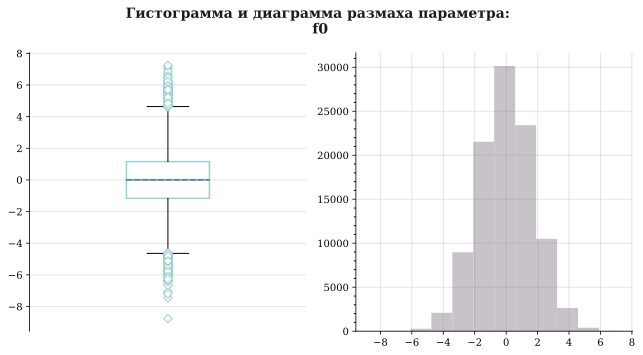

ShapiroResult(statistic=0.9999712705612183, pvalue=0.6420857310295105)

AndersonResult(statistic=0.6200969397032168, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0020226967336621432, scale=1.7320449040867434)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean    0.00
std     1.73
max     7.24
min    -8.76
50%     0.01
Name: f0, dtype: float64

Коэффициент асимметрии: 0.0 

Коэффициент эксцесса: 0.02 



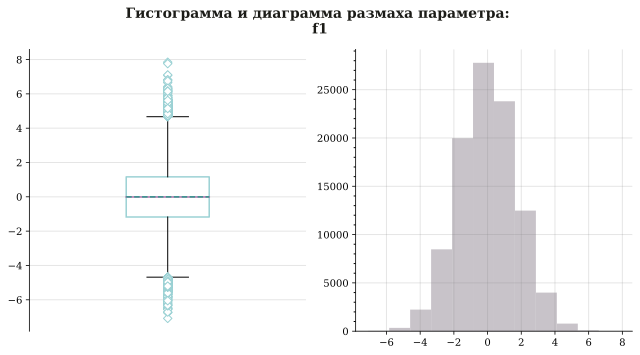

ShapiroResult(statistic=0.9999856352806091, pvalue=0.9895228147506714)

AndersonResult(statistic=0.5819387464580359, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.002080534450544628, scale=1.7304170849076967)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean   -0.00
std     1.73
max     7.84
min    -7.08
50%    -0.01
Name: f1, dtype: float64

Коэффициент асимметрии: 0.01 

Коэффициент эксцесса: -0.01 



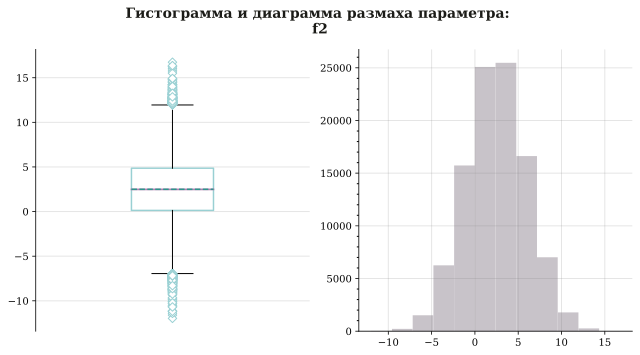

ShapiroResult(statistic=0.9999152421951294, pvalue=0.0038391456473618746)

AndersonResult(statistic=1.2259458785847528, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2.4951275797819124, scale=3.473444622693797)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean     2.50
std      3.47
max     16.74
min    -11.97
50%      2.48
Name: f2, dtype: float64

Коэффициент асимметрии: 0.0 

Коэффициент эксцесса: -0.07 



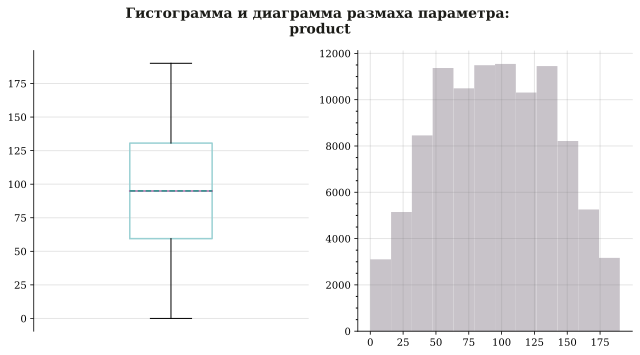

ShapiroResult(statistic=0.9827924370765686, pvalue=0.0)

AndersonResult(statistic=408.4873990392225, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=95.00000000000004, scale=44.74992106895222)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


mean     95.00
std      44.75
max     190.03
min       0.00
50%      94.93
Name: product, dtype: float64

Коэффициент асимметрии: 0.0 

Коэффициент эксцесса: -0.88 



In [24]:
show_distribution_graphs(region_3, 'region_3')
# вызов функции show_distribution_graphs для region_3

На основании результатов статистических тестов можно сделать вывод, что распределения признаков точек `f0`, `f1` и `f2` в **region_3** *близки к нормальному*. Несмотря на выбросы на диаграммах размаха `f0`, `f1`, `f2`, среднее и медиана каждого из параметров практически равны. 

Медианный показатель объёма запасов в скважинах - **94.93** тыс. баррелей. Распределение `product` *не является нормальным*.

Отдельно посмотрим на скважины с *нулевым* объёмом запасов.

In [25]:
region_1[region_1['product'] == 0]
# срез данных

,id,f0,f1,f2,product
57263,zCM5W,-0.702064,0.375992,0.236572,0.0


In [26]:
region_2[region_2['product'] == 0]
# срез данных

,id,f0,f1,f2,product
11,OXyvW,16.320755,-0.562946,-0.001783,0.0
13,igmai,6.695604,-0.749449,-0.007630,0.0
62,Qjy5w,21.418478,-5.134490,-0.002836,0.0
63,G6WCj,6.822701,3.104979,-0.000723,0.0
77,MzQhL,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...,...
99936,YrRU8,5.085749,-3.980305,0.005063,0.0
99948,Jbnur,8.277805,-9.178818,0.003275,0.0
99956,aV1cJ,13.343983,-1.290200,0.005980,0.0
99961,Zjbn2,13.854163,-11.528089,-0.005556,0.0


In [27]:
region_3[region_3['product'] == 0]
# срез данных

,id,f0,f1,f2,product
68149,qeefd,-0.865596,-1.615247,-4.126441,0.0


Больше всего таких точек в **region_2**. Возможно, в скважинах запасы нефти уже истощены или точной информации по залежам неизвестны. Будем учитывать эти строки при обучении моделей, так как они важны при оценке риска убытков в регионах.

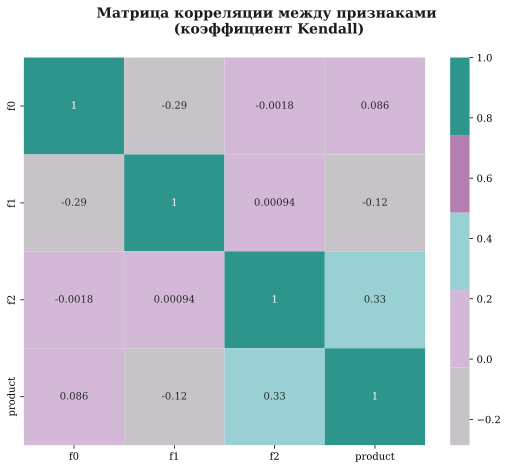

In [28]:
fig = plt.figure(figsize=(9, 7))
fig.suptitle(f'Матрица корреляции между признаками\n (коэффициент Kendall)', fontsize=14, fontweight='demi', color='#1B1B17')
ax1 = fig.add_subplot(1, 1, 1)
sns.heatmap(region_1.drop('id', axis=1).corr(method='kendall'), 
                                                          ax=ax1, 
                                                          cmap=['#C8C3C9', '#D3B9D7', '#99D0D3', '#B47EB2', '#2E958C'], 
                                                          annot=True)

plt.show()
# построение тепловой карты корреляций kendall

В **region_1** целевой признак имеет *слабую* корреляцию с переменной `f2`.

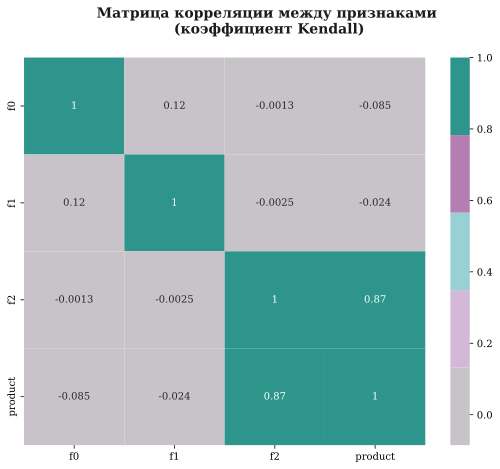

In [29]:
fig = plt.figure(figsize=(9, 7))
fig.suptitle(f'Матрица корреляции между признаками\n (коэффициент Kendall)', fontsize=14, fontweight='demi', color='#1B1B17')
ax1 = fig.add_subplot(1, 1, 1)
sns.heatmap(region_2.drop('id', axis=1).corr(method='kendall'), 
                                                          ax=ax1, 
                                                          cmap=['#C8C3C9', '#D3B9D7', '#99D0D3', '#B47EB2', '#2E958C'], 
                                                          annot=True)

plt.show()
# построение тепловой карты корреляций kendall

В **region_2** `product` *сильно* коррелирует с параметром `f2`. Коэффициент корреляции составляет **0.87**.

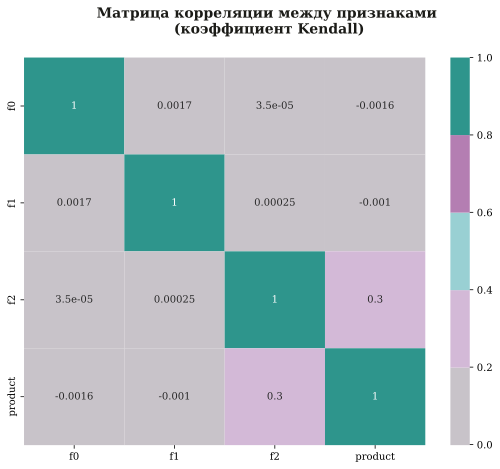

In [30]:
fig = plt.figure(figsize=(9, 7))
fig.suptitle(f'Матрица корреляции между признаками\n (коэффициент Kendall)', fontsize=14, fontweight='demi', color='#1B1B17')
ax1 = fig.add_subplot(1, 1, 1)
sns.heatmap(region_3.drop('id', axis=1).corr(method='kendall'), 
                                                          ax=ax1, 
                                                          cmap=['#C8C3C9', '#D3B9D7', '#99D0D3', '#B47EB2', '#2E958C'], 
                                                          annot=True)

plt.show()
# построение тепловой карты корреляций kendall

В **region_3** целевой признак `product` имеет *слабую* корреляцию с переменной `f2`.

### Вывод

На данном этапе мы подробно изучили распределения числовых переменных в выборках:

- определили медианные значения;
- нашли выбросы на диаграммах размаха;
- оценили нормальность распределений;
- обнаружили корреляцию между целевым признаком и параметром `f2` (сила корреляции при этом отличается в зависимости от региона);
- не выявили мультиколлинеарность между входными переменными.

## Обучение и проверка модели

In [31]:
def show_residuals_distribution(residuals, name, bins_num=15):
    fig = plt.figure(figsize=(6, 5))
    fig.suptitle(name, 
                 fontsize=16,
                 fontweight='demi',
                 color='#1B1B17')
    ax1 = fig.add_subplot(1, 1, 1)
    # создание сетки для отрисовки графиков
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    # убираем верхнюю и правую границы графиков
    ax1.set_title('Гистограмма распределения остатков', 
                  fontsize=14, 
                  loc='left',
                  fontweight='demi',
                  color='#1B1B17')
    # добавление названия для графика
    ax1.set_xlabel('Остатки', fontsize=12)
    ax1.set_ylabel('Частота', fontsize=12)
    # добавление подписей к осям
    
    sns.histplot(residuals,
                 color='#D3B9D7',
                 ax=ax1,
                 bins=bins_num
                )
    # создание гистограммы распределения
    
    return plt.show()
# создаём функцию для вывода графика распределения остатков

In [32]:
num_columns = ['f0',
               'f1',
               'f2']
# создаём список с названиями количественных признаков

In [33]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough'
)
# создаём общий пайплайн для подготовки данных - масштабирования

In [34]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])
# создаём итоговый пайплайн: подготовка данных и модель

*Ridge и Lasso* - версии линейной регрессии с разной степенью регуляризации. Существенное отличие регрессии Lasso от Ridge в том, что Lasso может занулять коэффициенты модели.

In [35]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    # словарь для модели LinearRegression()
    {
        'models': [Ridge()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    # словарь для модели Ridge()
    {
        'models': [Lasso()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
     # словарь для модели Lasso()
]

In [36]:
def get_model_results(data, name):
    
    X = data.drop(['id','product'], axis = 1)
    y = data['product']

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE
    )
    # разделение выборки на тренировочную и тестовую
    
    print(f'''
                  ----------
                 | {name} |
                  ----------
    ''')
    print(f'''Количество строк в тренировочной выборке: {X_train.shape[0]}
Количество признаков в тренировочной выборке: {X_train.shape[1]}''')
    print(f'''Количество строк в валидационной выборке: {X_valid.shape[0]}
Количество признаков в валидационной выборке: {X_valid.shape[1]}''')
    
    randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    scoring = 'neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
    )
    # запуск поиска гиперпараметров с помощью RandomizedSearchCV

    randomized_search.fit(X_train, y_train)
    # обучение модели
    
    y_pred = randomized_search.predict(X_valid)
    # получение предсказаний для выборки X_valid
    
    residuals = (y_valid.tolist()) - y_pred
    # подсчёт остатков
    
    print('')
    print (f'Метрика лучшей модели по тренировочной выборке: {round(randomized_search.best_score_ * (-1), 3)}')
    print(f'Метрика RMSE на валидационной выборке: {round(math.sqrt(mean_squared_error(y_valid, y_pred)), 3)}')
    print(f'Cредний запас предсказанного сырья: {round(y_pred.mean(), 3)}')
    show_residuals_distribution(residuals, name)
    return y_pred, y_valid
# создаём функцию для подготовки модели и оценки её качества


                  ----------
                 | region_1 |
                  ----------
    
Количество строк в тренировочной выборке: 75000
Количество признаков в тренировочной выборке: 3
Количество строк в валидационной выборке: 25000
Количество признаков в валидационной выборке: 3

Метрика лучшей модели по тренировочной выборке: 37.672
Метрика RMSE на валидационной выборке: 37.757
Cредний запас предсказанного сырья: 92.399


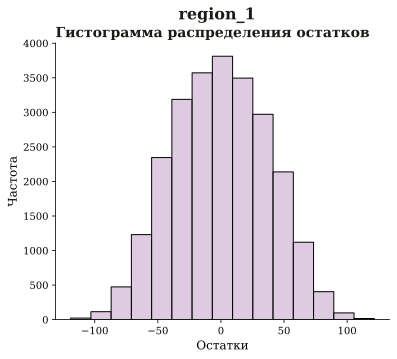

In [37]:
y_pred_reg_1, y_valid_reg_1 = get_model_results(region_1, 'region_1')
# применняем функцию get_model_results для region_1


                  ----------
                 | region_2 |
                  ----------
    
Количество строк в тренировочной выборке: 75000
Количество признаков в тренировочной выборке: 3
Количество строк в валидационной выборке: 25000
Количество признаков в валидационной выборке: 3

Метрика лучшей модели по тренировочной выборке: 0.89
Метрика RMSE на валидационной выборке: 0.89
Cредний запас предсказанного сырья: 68.713


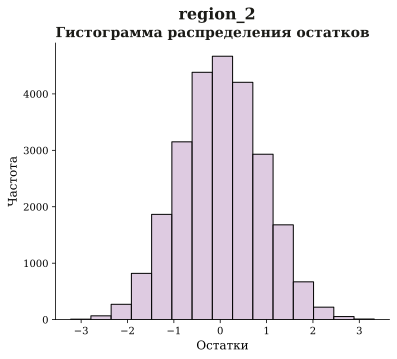

In [38]:
y_pred_reg_2, y_valid_reg_2 = get_model_results(region_2, 'region_2')
# применняем функцию get_model_results для region_2


                  ----------
                 | region_3 |
                  ----------
    
Количество строк в тренировочной выборке: 75000
Количество признаков в тренировочной выборке: 3
Количество строк в валидационной выборке: 25000
Количество признаков в валидационной выборке: 3

Метрика лучшей модели по тренировочной выборке: 40.027
Метрика RMSE на валидационной выборке: 40.146
Cредний запас предсказанного сырья: 94.771


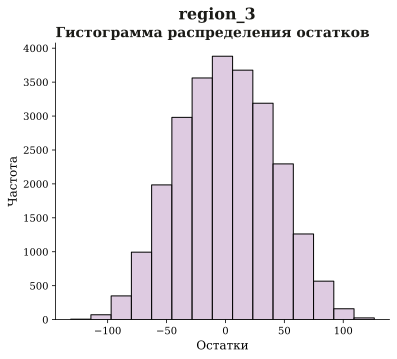

In [39]:
y_pred_reg_3, y_valid_reg_3 = get_model_results(region_3, 'region_3')
# применняем функцию get_model_results для region_3

Самая маленькая среднеквадратичная ошибка rmse у второго региона **region_2** - всего **0.89**. На втором месте region_1 c показателем rmse *37.75*. Самая большая среднеквадратичная ошибка у region_3 - *40.15*.

По среднему запасу предсказанного сырья лидирует **region_3** с **94.7** тыс. баррелей на скважину. Далее следует region_1, где в среднем объём запасов в скважине равен *92.4* тыс. баррелей. На последнем месте region_2 - *68.7* тыс. баррелей.

## Подготовка к расчёту прибыли

In [40]:
y_valid_reg_1 = y_valid_reg_1.reset_index(drop=True)
y_valid_reg_2 = y_valid_reg_2.reset_index(drop=True)
y_valid_reg_3 = y_valid_reg_3.reset_index(drop=True)
# обновляем индексы в датафреймах

In [41]:
BUDJET_PER_REG = 10 ** 10
INCOME_PER_PRODUCT_UNIT = 450_000
REGION_EXPLORATION_POINTS = 500
BEST_POINTS = 200
MAX_LOSS_PROBABILITY = 0.025
# сохраняем все ключевые значения для расчётов в отдельных переменных

In [42]:
break_even_volume = round(BUDJET_PER_REG / INCOME_PER_PRODUCT_UNIT / BEST_POINTS, 3)
print(f'Достаточный объём сырья (тыс. баррелей) для безубыточной разработки новой скважины: {break_even_volume}')

Достаточный объём сырья (тыс. баррелей) для безубыточной разработки новой скважины: 111.111


In [43]:
def count_points_percent(product_values, min_volume, name):
    print(f'''
                  ----------
                 | {name} |
                  ----------
    ''')
    print(product_values.describe())
    print('')
    print(f'Процент скважин с достаточным объёмом сырья для безубыточной разработки: {(round((product_values >= min_volume).sum() / len(product_values) * 100, 3))}%')
    print(f'Количество скважин с достаточным объёмом сырья для безубыточной разработки: {(product_values >= min_volume).sum()}')
# создаём функцию для определения скважин с достаточным объёмом сырья для безубыточной разработки    

In [44]:
count_points_percent(region_1['product'], break_even_volume, 'region_1')
# используем функцию count_points_percent для region_1


                  ----------
                 | region_1 |
                  ----------
    
count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

Процент скважин с достаточным объёмом сырья для безубыточной разработки: 36.583%
Количество скважин с достаточным объёмом сырья для безубыточной разработки: 36583


In [45]:
count_points_percent(region_2['product'], break_even_volume, 'region_2')
# используем функцию count_points_percent для region_2


                  ----------
                 | region_2 |
                  ----------
    
count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

Процент скважин с достаточным объёмом сырья для безубыточной разработки: 16.537%
Количество скважин с достаточным объёмом сырья для безубыточной разработки: 16537


In [46]:
count_points_percent(region_3['product'], break_even_volume, 'region_3')
# используем функцию count_points_percent для region_3


                  ----------
                 | region_3 |
                  ----------
    
count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

Процент скважин с достаточным объёмом сырья для безубыточной разработки: 38.178%
Количество скважин с достаточным объёмом сырья для безубыточной разработки: 38178


Достаточный объём сырья для безубыточной разработки новой скважины равен **111.1** тыс. баррелей. В то же время, средний запас предсказанного сырья в скважинах для каждого региона *ниже* безубыточного уровня. В нашем случае *уровень безубыточной разработки* - это минимальный объём сырья, который можно продать и полностью покрыть расходы на разработку (доходы равны расходам). Объём нефти, превышающий данный уровень, будет переходить в чистую прибыль.  

В **region_3** *38%* скважин имеют достаточный запас нефти для безубыточной разработки. В первом регионе запасы в *36.6%* точек превышают минимальный уровень. Только лишь *16.5%* скважин в region_2 подходят для безубыточной добычи.

## Расчёт прибыли и рисков

In [47]:
def calculate_income(y_pred, y_valid):
    y_valid = y_valid.reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)
    df_sorted = y_pred.sort_values(ascending=False)[:BEST_POINTS]
    best_points_volume = y_valid[df_sorted.index].sum()
    return best_points_volume * INCOME_PER_PRODUCT_UNIT - BUDJET_PER_REG
# создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [48]:
print(f'Прибыль лучших 200 лучших точек региона 1: {calculate_income(y_pred_reg_1, y_valid_reg_1)}')

Прибыль лучших 200 лучших точек региона 1: 3359141114.462179


In [49]:
print(f'Прибыль лучших 200 лучших точек региона 2: {calculate_income(y_pred_reg_2, y_valid_reg_2)}')

Прибыль лучших 200 лучших точек региона 2: 2415086696.681511


In [50]:
print(f'Прибыль лучших 200 лучших точек региона 3: {calculate_income(y_pred_reg_3, y_valid_reg_3)}')

Прибыль лучших 200 лучших точек региона 3: 2598571759.374111


In [51]:
def get_income_and_risk(pred, target, name):
    income = []
    for i in range(1000):
        target_subsample = target.sample(n=REGION_EXPLORATION_POINTS, replace=True, random_state=state)
        pred_subsample = pd.Series(pred)[target_subsample.index]
        income.append(calculate_income(pred_subsample, target_subsample))
    
    income = pd.Series(income)
    print(f'''
               ----------
              | {name} |
               ----------
    ''')
    print(f'Средняя прибыль 200 лучших точек региона: {round(income.mean(), 3)}')
    print(f'Вероятность убытков в регионе: {round(((income < 0).sum()) / len(income) * 100, 3)}%')
    print(f'95% доверительный интервал прибыли региона: [{round(np.percentile(income, 2.5), 3)}, {round(np.percentile(income, 97.5), 3)}]')
    fig = plt.figure(figsize=(7, 4))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title(f'Распределение прибыли в {name}',
                  fontsize=14,
                  fontweight='demi',
                  color='#1B1B17')
    ax1.set_ylabel('Частота', fontsize=12)
    ax1.set_xlabel('Прибыль, млрд. руб.', fontsize=12)
    sns.histplot(income, color='#99D0D3', ax=ax1)
    return plt.show()
# создание функции для расчёта прибыли на 1000 выборках с применением техники Bootstrap, оценка рисков       


               ----------
              | region_1 |
               ----------
    
Средняя прибыль 200 лучших точек региона: 406278376.214
Вероятность убытков в регионе: 6.7%
95% доверительный интервал прибыли региона: [-117742136.495, 911737050.751]


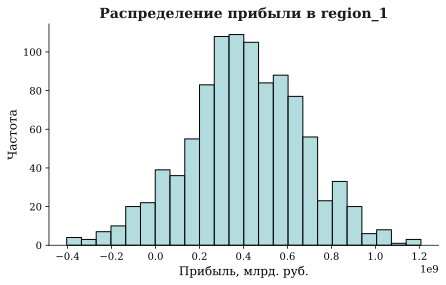

In [52]:
get_income_and_risk(y_pred_reg_1, y_valid_reg_1, 'region_1')
# использование функции get_income_and_risk для region_1


               ----------
              | region_2 |
               ----------
    
Средняя прибыль 200 лучших точек региона: 441504277.592
Вероятность убытков в регионе: 1.6%
95% доверительный интервал прибыли региона: [35728489.281, 828006639.004]


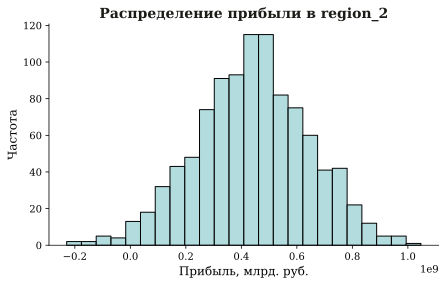

In [53]:
get_income_and_risk(y_pred_reg_2, y_valid_reg_2, 'region_2')
# использование функции get_income_and_risk для region_2


               ----------
              | region_3 |
               ----------
    
Средняя прибыль 200 лучших точек региона: 385213195.914
Вероятность убытков в регионе: 7.8%
95% доверительный интервал прибыли региона: [-164785166.109, 888206234.198]


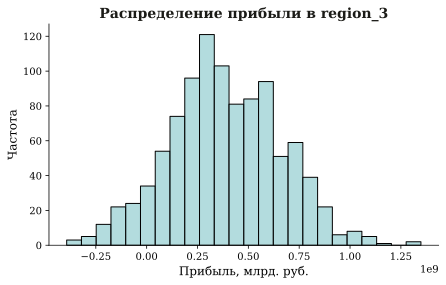

In [54]:
get_income_and_risk(y_pred_reg_3, y_valid_reg_3, 'region_3')
# использование функции get_income_and_risk для region_3

Минимальный риск убытков **1.6%** наблюдается во **втором** регионе. Для region_1 и region_3 вероятность убытков составляет *6.7%* и *7.8%* соответственно.

По средней прибыли c 200 лучших точек регионы распределяются следующим образом:
* region_2 - *441504277.592*
* region_1 - *406278376.214*
* region_3 - *385213195.914*

## Итоговый вывод

На начальном этапе была проведена предобработка данных. Полные дубликаты, пропуски и некорректные типы данных не были найдены. Скважины с одинаковыми `id`, но разными значениями параметров, мы решили оставить в датафреймах.

В ходе исследовательского анализа данных были рассмотрены все числовые признаки. С помощью гистограмм и статистических тестов мы оценили характер распределенний, а по диаграммам размаха определили медианные значения параметров и проверили наличие выбросов. Далее на этапе корреляционного анализа мы построили матрицы корреляций. Мультиколлинеарность между признаками не была обнаружена. Мы выявили корреляцию между целевым признаком и параметром `f2` для всех регионов, но самый высокий коэффициент 0.87 наблюдался в region_2.

Для построения моделей мы использовали функцию с общим пайплайном и инструментом для подбора гиперпараметров - RandomizedSearchCV. На этапе подготовки признаков числовые параметры были приведены к единой шкале. Самая маленькая среднеквадратичная ошибка rmse была определена для второго региона (0.89). Самый высокий уровень среднего запаса предсказанного сырья в скважинах в третьем регионе - 94.7 тыс. баррелей. 

Далее мы определили достаточный объём сырья для безубыточной разработки новой скважины - 111.1 тыс. баррелей. В нашем случае уровень безубыточной разработки - это минимальный объём сырья, который можно продать и полностью покрыть расходы на разработку. Самая большая доля скважин, которые имеют достаточный запас нефти для безубыточной разработки (38%) находятся в region_3. 

На основе расчётов рисков и прибыли для скважин в каждом регионе можно предложить второй регион region_2 для разработки скважин, так как вероятность получить убыток в данном регионе минимальная (1.6%), а средняя прибыль c 200 лучших точек наибольшая среди регионов - 441504277.592.